In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2022-dl-w10-p2/valid.csv
/kaggle/input/2022-dl-w10-p2/train.csv
/kaggle/input/2022-dl-w10-p2/test.csv
/kaggle/input/2022-dl-w10-p2/sample_submit.csv


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
# from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train=pd.read_csv('/kaggle/input/2022-dl-w10-p2/train.csv')
valid=pd.read_csv('/kaggle/input/2022-dl-w10-p2/valid.csv')
test=pd.read_csv('/kaggle/input/2022-dl-w10-p2/test.csv')
submit=pd.read_csv('/kaggle/input/2022-dl-w10-p2/sample_submit.csv')
print(train.shape,valid.shape,test.shape)

(1712, 30002) (300, 30002) (50, 30001)


In [4]:
train.head()

,id,1,2,3,4,5,6,7,8,9,...,29992,29993,29994,29995,29996,29997,29998,29999,30000,label
0,0,128,131,138,128,131,138,130,133,138,...,120,118,119,119,117,118,119,117,118,1
1,1,107,108,113,107,108,113,108,109,114,...,129,129,131,129,129,131,129,129,131,7
2,2,119,122,129,121,124,131,124,127,134,...,96,96,98,94,94,96,93,93,95,0
3,3,129,128,126,131,130,128,135,134,132,...,109,108,106,106,105,103,103,102,100,7
4,4,132,131,129,133,132,130,136,135,133,...,113,109,106,111,107,104,110,106,103,5


In [5]:
valid.head()

,id,1,2,3,4,5,6,7,8,9,...,29992,29993,29994,29995,29996,29997,29998,29999,30000,label
0,0,121,122,127,122,123,128,123,124,129,...,96,96,96,95,95,95,94,94,94,8
1,1,116,116,118,119,119,121,121,122,124,...,93,94,96,92,93,95,90,91,93,0
2,2,125,125,127,126,126,128,127,127,127,...,105,106,111,103,104,109,102,103,108,4
3,3,124,124,132,125,125,133,126,127,132,...,115,113,114,114,112,113,113,111,112,2
4,4,121,122,127,122,123,128,125,126,131,...,83,83,83,82,82,82,81,81,81,9


In [6]:
test.head()

,id,1,2,3,4,5,6,7,8,9,...,29991,29992,29993,29994,29995,29996,29997,29998,29999,30000
0,0,122,122,130,125,125,133,127,128,133,...,108,107,107,107,106,106,106,106,106,106
1,1,113,112,107,116,115,110,120,119,114,...,120,127,122,118,125,120,116,123,118,114
2,2,116,117,122,118,119,124,120,121,126,...,95,96,96,94,95,95,93,94,94,92
3,3,116,116,114,117,117,115,119,119,119,...,112,104,105,109,102,103,107,102,103,107
4,4,129,129,131,129,129,131,130,130,132,...,115,109,110,114,108,109,113,108,109,113


In [7]:
x0=train.drop(['id','label'],axis=1)
y0=train['label']
vx0=valid.drop(['id','label'],axis=1)
vy0=valid['label']
tx0=test.iloc[:,1:]

In [8]:
x_train=np.array(x0).reshape(1712,100,100,-1)
x_valid=np.array(vx0).reshape(300,100,100,-1)
x_test=np.array(tx0).reshape(50,100,100,-1)
print(x_train.shape, x_valid.shape, x_test.shape)

(1712, 100, 100, 3) (300, 100, 100, 3) (50, 100, 100, 3)


In [9]:
# mean = np.mean(x_train, axis=(0,1,2,3))
# std = np.std(x_train, axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_valid = (x_valid-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(x_train)

In [11]:
from keras.utils import np_utils
num_classes = 10
y_train = np_utils.to_categorical(y0, num_classes)
y_valid = np_utils.to_categorical(vy0, num_classes)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = 224

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
layers.experimental.preprocessing.Rescaling(1./255)
])

x_train = resize_and_rescale(x_train)
x_valid = resize_and_rescale(x_valid)
x_test = resize_and_rescale(x_test)

2022-11-13 10:20:37.296439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 10:20:37.402211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 10:20:37.403019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 10:20:37.405035: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
print(x_train.shape, x_valid.shape, x_test.shape)

(1712, 224, 224, 3) (300, 224, 224, 3) (50, 224, 224, 3)


In [14]:
base_model = vgg16.VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3), pooling='avg')

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
for layer in base_model.layers[:-5]:
    layer.trainable = False
    
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
last_output=base_model.output
x=Dense(10, activation='softmax', name='softmax')(last_output)
new_model = Model(inputs=base_model.input, outputs=x)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

new_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5',verbose=1,save_best_only=True)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
history=new_model.fit(x_train,y_train,batch_size=10,steps_per_epoch=18,
                      epochs=35,validation_data=(x_valid, y_valid),validation_steps=3,verbose=2,callbacks=[checkpointer])

2022-11-13 10:20:41.464069: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1030815744 exceeds 10% of free system memory.
2022-11-13 10:20:42.287744: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/35


2022-11-13 10:20:43.909085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


18/18 - 10s - loss: 2.3583 - accuracy: 0.1167 - val_loss: 2.2126 - val_accuracy: 0.2333

Epoch 00001: val_loss improved from inf to 2.21257, saving model to signlanguage.model.hdf5
Epoch 2/35
18/18 - 1s - loss: 2.2448 - accuracy: 0.1444 - val_loss: 2.1917 - val_accuracy: 0.3000

Epoch 00002: val_loss improved from 2.21257 to 2.19171, saving model to signlanguage.model.hdf5
Epoch 3/35
18/18 - 1s - loss: 2.1396 - accuracy: 0.3667 - val_loss: 2.1955 - val_accuracy: 0.2667

Epoch 00003: val_loss did not improve from 2.19171
Epoch 4/35
18/18 - 1s - loss: 2.0637 - accuracy: 0.4222 - val_loss: 2.1324 - val_accuracy: 0.3333

Epoch 00004: val_loss improved from 2.19171 to 2.13235, saving model to signlanguage.model.hdf5
Epoch 5/35
18/18 - 1s - loss: 1.8971 - accuracy: 0.3500 - val_loss: 1.9982 - val_accuracy: 0.4667

Epoch 00005: val_loss improved from 2.13235 to 1.99821, saving model to signlanguage.model.hdf5
Epoch 6/35
18/18 - 1s - loss: 1.7276 - accuracy: 0.5500 - val_loss: 1.8643 - val_acc

In [20]:
new_model.load_weights('signlanguage.model.hdf5')

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython

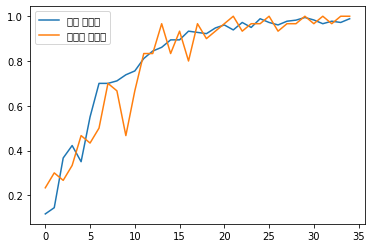

In [21]:
plt.plot(history.history['accuracy'], label='훈련 데이터')
plt.plot(history.history['val_accuracy'], label='테스트 데이터')
plt.legend()
plt.show()

In [22]:
prediction = new_model.predict( x_test,
                            batch_size=None,
                            verbose="auto",
                            steps=None,
                            callbacks=None,
                            max_queue_size=10,
                            workers=1,
                            use_multiprocessing=False,
                        )

In [23]:
prediction.shape

(50, 10)

In [24]:
submit.head()

,id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [25]:
submit['label']=np.argmax(prediction,axis=1)

In [26]:
submit.head()

,id,label
0,0,5
1,1,5
2,2,0
3,3,0
4,4,2


In [27]:
submit.to_csv('submission.csv',index=False)